# Gas Boiler to heat pump dynamic Material Flow analysis
This doc uses the dynamic_stock_model package

The objective is to replace every boiler by heat pumps by 2050 in Vaud Canton

## Import data

In [95]:
import dynamic_stock_model as dsm 
import copy
import numpy as np
import matplotlib.pyplot as plt
import openpyxl


In [96]:
# Vaud number housing
housing_2024= 381144

# increase of the number of housing

housing_increase_2024 = 1/100 # 1/100 is the actual rate

# Proportion of HP
prop_HP_2024 = 0.17
# Proportion of GB
prop_GB_2024 = 0.30

# Lifetime HP
lifetime_HP_2024 = [20]*(61)  # from 2015 to 2050

# Lifetime GB
lifetime_GB_2024 = [20]*(61)  # from 1990 to 2050

# std lifetime 
std_GB=0.25
std_HP=0.25

# density functions
HP_pdf='Normal'
GB_pdf='Normal'

# Define time range
Years = np.arange(2015, 2051) # 2015 to 2025 is the initialisation then 2025 to 2050 is the projection



In [97]:

def polyfit_fixed_last_point(x, y, degree=2):
    """
    Fits a polynomial of a given degree to data, forcing it through the last point.
    """
    # Define the fixed point (last point in the dataset)
    xf, yf = x[-1], y[-1]
    
    # Create the new variables
    y_prime = y - yf
    
    # Construct the design matrix for the new linear system
    # For a 2nd degree polynomial, columns are (x - xf) and (x^2 - xf^2)
    X_prime = np.vstack([x**i - xf**i for i in range(1, degree + 1)]).T
    
    # Solve the linear system for coefficients (a1, a2, ...)
    # np.linalg.lstsq solves A @ b = y for b (here, X_prime @ a_prime = y_prime)
    a_prime, residuals, rank, singular_values = np.linalg.lstsq(X_prime, y_prime, rcond=None)
    
    # Calculate a0 using the constraint equation
    a0 = yf - sum(coeff * (xf**i) for i, coeff in enumerate(a_prime, 1))
    
    # Combine coefficients into the standard order (a2, a1, a0) for np.poly1d
    # Note: np.poly1d expects [a_deg, a_deg-1, ..., a0]
    coeffs_standard_order = np.insert(a_prime, 0, a0)[::-1]
    
    return np.poly1d(coeffs_standard_order), a0, a_prime

## Initial parameters


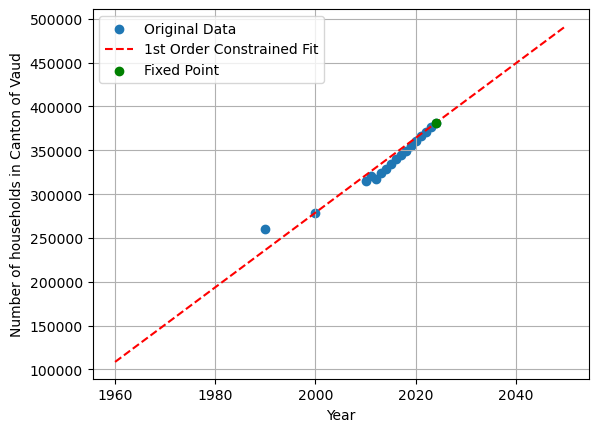

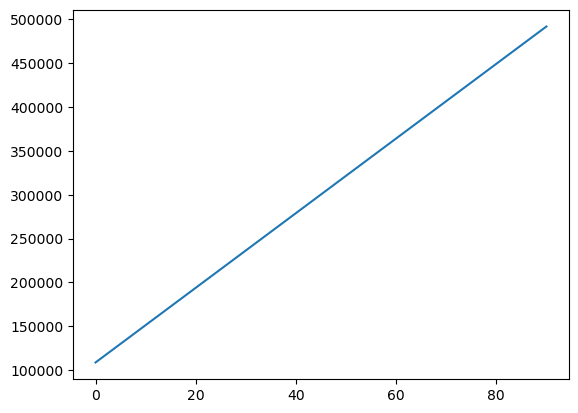

In [98]:


# Calculate housing increase over time for future years
Dates_housing=[1990, 2000, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Housing_data=[260060, 278752, 314596, 321158, 317243, 323577, 328414,333955,339882, 344627, 349758, 354496, 360928, 366389, 370394, 376518, housing_2024]

# --- Usage ---
# Sample data
x = np.array(Dates_housing)
y = np.array(Housing_data)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = np.arange(1960, 2051)
y_fit = polynomial_func(x_new)

# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit, '--',color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Year')
plt.ylabel('Number of households in Canton of Vaud')
#plt.title('First order regression for housing increase')
plt.legend()
plt.grid(True)
plt.show()



Housing=y_fit.tolist()
plt.plot(Housing)

## Create the models

[5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 5717.16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] 61
114343.2
Dimension check GB: ('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is not present.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,

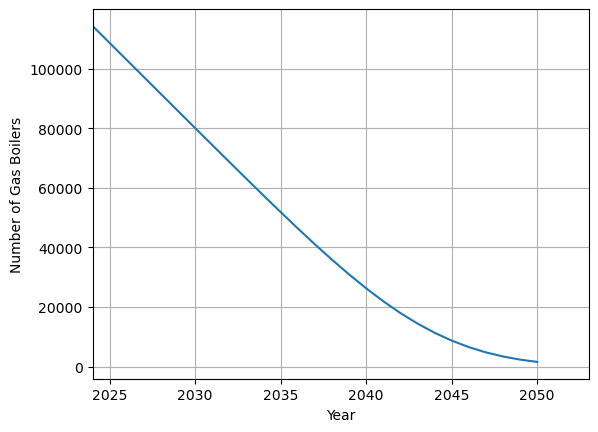

In [99]:
# inflow driven model for Gas boilers
# over 2004-2024 and then projection 2025-2050
# Use previous import of GB sales in Vaud
GB_sales =[housing_2024*prop_GB_2024/20]*(2025-1990)+[0]*26
print(GB_sales, len(GB_sales))
Years_GB=np.arange(1990,2051)
GB_DSM = dsm.DynamicStockModel(t = Years_GB, 
                               i =GB_sales, lt = {'Type': GB_pdf, 'Mean': lifetime_GB_2024, 'StdDev': std_GB* np.array(lifetime_GB_2024)},)

print(housing_2024*prop_GB_2024)
check_GB=GB_DSM.dimension_check()
print("Dimension check GB:", check_GB)
# compute stock
S_C, O_C= GB_DSM.compute_s_c_inflow_driven()
O_C= GB_DSM.compute_o_c_from_s_c()

S=GB_DSM.compute_stock_total()
O=GB_DSM.compute_outflow_total()


# plot stock
print('GB in 2024:', GB_DSM.s[2024-2051], 'theoretical=', housing_2024*prop_GB_2024)
plt.grid()
plt.plot( GB_DSM.t,GB_DSM.s, label='Gas Boilers Stock')
#plt.title('Gas Boilers Stock over time')
plt.xlabel('Year')
plt.ylabel('Number of Gas Boilers')
plt.xlim(2024)
#plt.hlines(housing_2024*prop_GB_2024,xmin=2000, xmax=2024, color='red', linestyles='dashed', label='2024 GB Stock Target')
#plt.legend(loc='lower right')
plt.show()



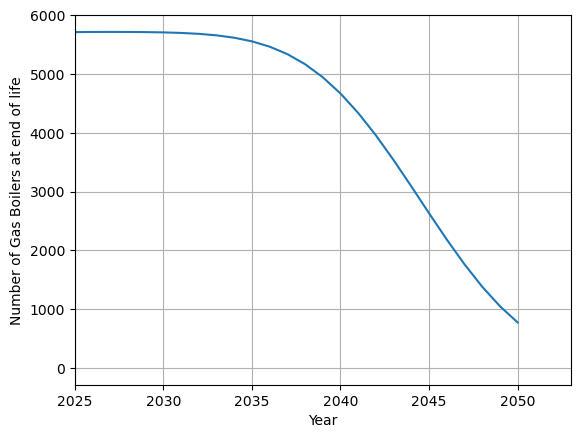

In [100]:
# plot stock

plt.grid()
plt.plot( GB_DSM.t,GB_DSM.o, label='Gas Boilers Stock')
#plt.title('Gas Boilers exports over time')
plt.xlabel('Year')
plt.xlim(2025)
plt.ylabel('Number of Gas Boilers at end of life')
plt.show()

35


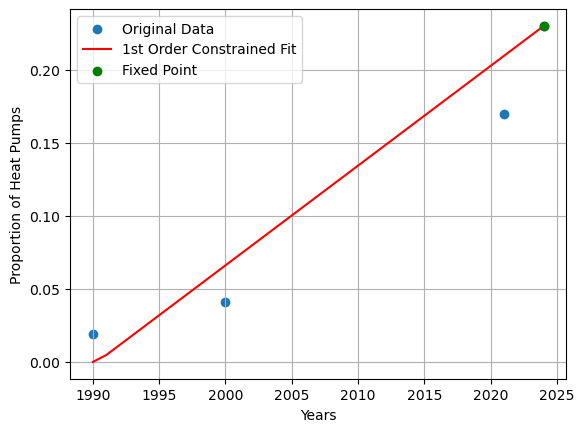

In [101]:
# Model for the heat pumps STOCK driven model
# past stock


Years_HP=np.arange(1990, 2025)
Data_past=[1990, 2000, 2021, 2024]
Data_past_HP=[1.9/100, 4.1/100, 17/100, 23/100]




# --- Usage ---
# Sample data
x = np.array(Data_past)
y = np.array(Data_past_HP)

# Perform the constrained fit
polynomial_func, a0, a_prime = polyfit_fixed_last_point(x, y, degree=1)

# Generate points for plotting the curve
x_new = Years_HP
y_fit = polynomial_func(x_new)
print(len(y_fit))
# Plotting
plt.scatter(x, y, label='Original Data')
plt.plot(x_new, y_fit.clip(min=0), color='red', label='1st Order Constrained Fit')
plt.scatter(x[-1], y[-1], color='green', zorder=5, label='Fixed Point') # Highlight fixed point
plt.xlabel('Years')
plt.ylabel('Proportion of Heat Pumps')
#plt.title('First Order Polynomial Regression Forcing Last Point')
plt.legend()
plt.grid(True)
plt.show()

# Print coefficients
# print(f"Coefficients (a0, a1, a2): {a0}, {a_prime[0]}, {a_prime[1]}")
# print(f"Function: {polynomial_func}")


HP_stock_i=[x*h for x,h in zip(y_fit.clip(min=0).tolist(),Housing)]

In [102]:
# from 2025 to 2050
H=[HP_stock_i[-1]]*(2050-2024) #63651
Housing_increase=[h-housing_2024 for h in Housing]

GB_to_HP=np.array(GB_DSM.o).cumsum()

HP_stock_f = [a + b + (prop_GB_2024+prop_HP_2024)*hi for a,b,hi in zip(H,GB_to_HP,Housing_increase[-(2050-2024):])]  #  2025 to 2050 is the projection

# total stock
HP_stock= HP_stock_i + HP_stock_f

# add new DSM for heat pumps

HP_DSM = dsm.DynamicStockModel(t = np.arange(1990,2051), 
                               s =HP_stock, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow is not present.<br>Total stock is present with 61 years.<br>Stock by cohorts is not present.<br>Total outflow is not present.<br>Outflow by cohorts is not present.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, '% of Heat pumps')

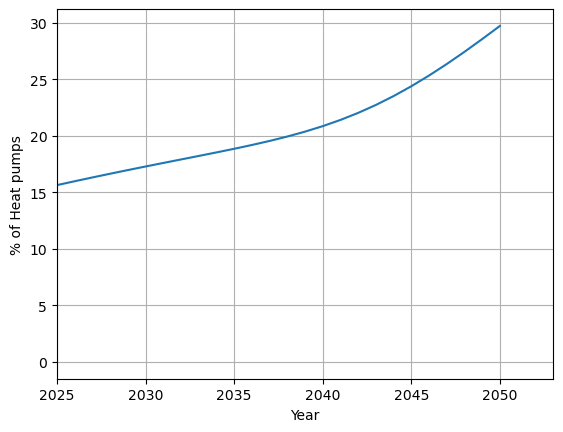

In [103]:
# compute stock driven model to get inflow
check_HP=HP_DSM.dimension_check()
print(check_HP)
I_C1= HP_DSM.compute_stock_driven_model()

S1=HP_DSM.compute_stock_total()

O1=HP_DSM.compute_outflow_total()
# plot stock

plt.grid()
plt.plot( HP_DSM.t,np.array(HP_DSM.s)/(Housing[30:])*100, label='Heat pump Stock') #[-16] for 2035
#plt.title('Heat pump Stock over time (% of housing in 2035)')
plt.xlabel('Year')
#plt.hlines(50,xmin=2000, xmax=2050, color='red', linestyles='dashed', label='50% Target for 2035')
plt.xlim(2025)
plt.ylabel('% of Heat pumps')

Text(0, 0.5, 'Heat pumps')

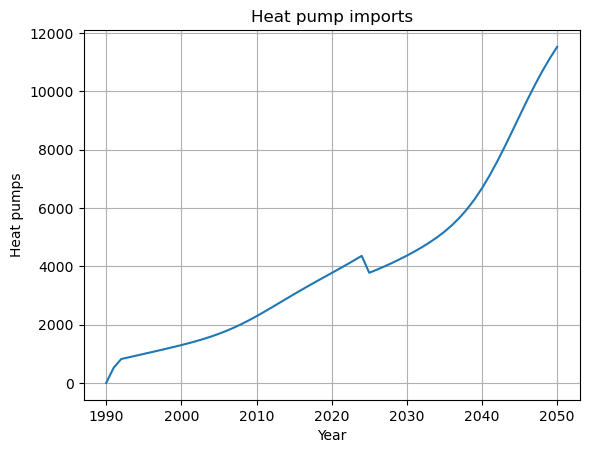

In [104]:
# plot stock

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')
plt.title('Heat pump imports')
plt.xlabel('Year')
plt.ylabel('Heat pumps')

## Calculating an incentive to buy HP 
Target of 55% in 2035(from https://www.sciencedirect.com/science/article/pii/S0301421525002253)

[np.float64(60285.106931198105), np.float64(62286.63299874197), np.float64(64288.85873453359), np.float64(66292.49342915346), np.float64(68298.8541665137), np.float64(70310.28242116817), np.float64(72330.76145645621), np.float64(74366.77169342106), np.float64(76428.38855295), np.float64(78530.56819712628), np.float64(80694.48284012468), np.float64(82948.67162052939), np.float64(85329.6908327733), np.float64(87881.91322050401), np.float64(90656.17415745629), np.float64(93707.11216388694), np.float64(97089.29276187476), np.float64(100852.49303399638), np.float64(105036.78516918527), np.float64(109668.20803403192), np.float64(114755.79426844255), np.float64(120290.51123251091), np.float64(126246.32005964659), np.float64(132583.14856091602), np.float64(139251.21965374268), np.float64(146195.96781604766)]
17757.304692318867


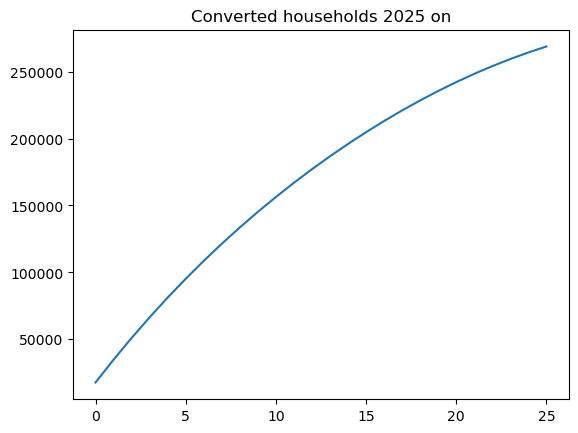

In [105]:
incentive_HP=5.5/100 #<- result: percentage of households that don't have converted yet but will convert due to incentives

# calculate converted households
Converted_households=[incentive_HP*(housing_2024-HP_stock_i[-1])]

for i in range(1,26):
    Converted_households.append(max(incentive_HP*(Housing[-26+i]-HP_stock[-26+i]-Converted_households[-1])+Converted_households[-1],Converted_households[-1]))
plt.plot(Converted_households)
plt.title("Converted households 2025 on")

HP_stock_f1 = [a+ b for a,b in zip(HP_DSM.s[-26:],Converted_households)]
print(HP_DSM.s[-26:])
print(Converted_households[0])



78042.41162351696


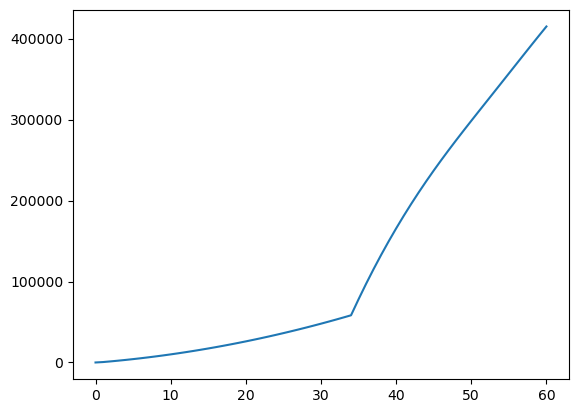

In [106]:

# total stock
HP_stock1= HP_stock_i + HP_stock_f1
print(HP_stock_f1[0])
plt.plot(HP_stock1)

# add new buildings

HP_DSM_incentive = dsm.DynamicStockModel(t = np.arange(1990, 2051), 
                               s =HP_stock1, lt = {'Type': HP_pdf, 'Mean': lifetime_HP_2024, 'StdDev': std_HP* np.array(lifetime_HP_2024)},)

55.37895295533923


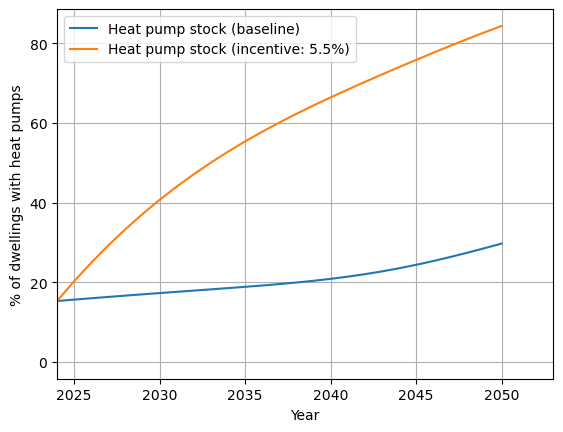

In [107]:
# compute stock driven model to get inflow (si pas déjà fait avant)
HP_inc = HP_DSM_incentive.compute_stock_driven_model()
S_inc  = HP_DSM_incentive.compute_stock_total()
O_inc  = HP_DSM_incentive.compute_outflow_total()
check_HP_inc = HP_DSM_incentive.dimension_check()

Housing_array = np.array(Housing)  # same lenght que HP_DSM.t = 1990–2050

# plot stock

plt.grid()
plt.plot(HP_DSM.t,100 * np.array(HP_DSM.s) / Housing_array[30:],label='Heat pump stock (baseline)')
plt.plot(
    HP_DSM_incentive.t,100 * np.array(HP_DSM_incentive.s) / Housing_array[30:],label=f'Heat pump stock (incentive: {incentive_HP*100:.1f}%)')
#plt.title('Heat pump stock over time (% of dwellings)')
plt.xlim(2024)
plt.xlabel('Year')
plt.ylabel('% of dwellings with heat pumps')
plt.legend()
print(np.array(HP_DSM_incentive.s)[-16]*100 / Housing_array[-16])


In [108]:
# compute stock driven model to get inflow
HP_inc= HP_DSM_incentive.compute_stock_driven_model()

S_inc=HP_DSM_incentive.compute_stock_total()
O_inc=HP_DSM_incentive.compute_outflow_total()
check_HP_inc=HP_DSM_incentive.dimension_check()

print(check_HP_inc)


('<br><b> Checking dimensions of dynamic stock model DSM.Time vector is present with 61 years.<br>Inflow vector is present with 61 years.<br>Total stock is present with 61 years.<br>Stock by cohorts is present with 61 years and 61 cohorts.<br>Total outflow is present with 61 years.<br>Outflow by cohorts is present with 61 years and 61 cohorts.<br>Lifetime distribution is present with type Normal and mean [20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20].<br>', 1)


Text(0, 0.5, 'Heat pumps')

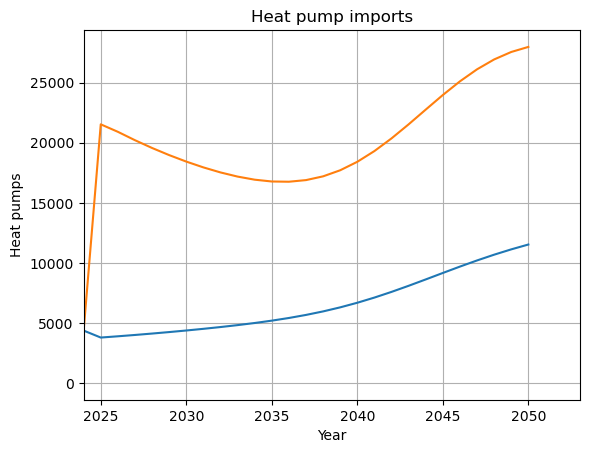

In [109]:

plt.grid()
plt.plot( HP_DSM.t,HP_DSM.i, label='Heat pump import')

plt.plot( HP_DSM_incentive.t,HP_DSM_incentive.i, label='Heat pump import with incentive')
plt.title('Heat pump imports')
plt.xlabel('Year')
plt.xlim(2024)
plt.ylabel('Heat pumps')

# Flow modelling:
electricity import,
gas import,
CO2 emissions,
Copper use, copper waste

In [110]:
# Data

# Household energy consumption
S_household=95 #m2 de surface habitable average
cons_surface=30 #kWh/m² par an

# Heat pump
COP=3.26 # Coefficient of performance

# Gas boiler
LHV_gas= 50 # MJ/kg
efficiency_GB=0.9

# emissions
e_elec= 0.0273 #kgCO2/kWh
e_gas_boiler= 0.0754 #kgCO2/MJ  !!
e_HP_manufacture=1010+81-175 #kgCO2/unit (assembly+transport+End of Life)

# Copper
copper_HP= 25 #kg
copper_GB= 1.5 #kg

## Electricity imports

In [111]:
# electricity needs per household

elec_need_HP= S_household*cons_surface/COP  #kWh/year

# electricity needs total per year
Elec_imports=np.array(HP_DSM.s)*elec_need_HP/1000000  #GWh/year
Elec_imports_inc=np.array(HP_DSM_incentive.s)*elec_need_HP/1000000  #GWh/year
print(Elec_imports)
print(Elec_imports_inc)

[  0.           0.45693449   1.17365215   1.94121283   2.75961653
   3.62886323   4.54895296   5.51988569   6.54166145   7.61428021
   8.73774199   9.91204679  11.1371946   12.41318542  13.74001926
  15.11769611  16.54621598  18.02557886  19.55578476  21.13683367
  22.7687256   24.45146054  26.1850385   27.96945947  29.80472345
  31.69083045  33.62778046  35.61557349  37.65420953  39.74368859
  41.88401066  44.07517575  46.31718385  48.61003497  50.9537291
  52.70323765  54.45303805  56.20345012  57.95509395  59.70912097
  61.46757819  63.2339479   65.0138955   66.81622926  68.65402434
  70.54579021  72.51647672  74.5980426   76.82927996  79.25463078
  81.92186186  84.87867619  88.16859054  91.82663734  95.87558064
 100.32331708 105.16195    110.36871539 115.9085808  121.73802945
 127.80935837]
[  0.           0.45693449   1.17365215   1.94121283   2.75961653
   3.62886323   4.54895296   5.51988569   6.54166145   7.61428021
   8.73774199   9.91204679  11.1371946   12.41318542  13.74001

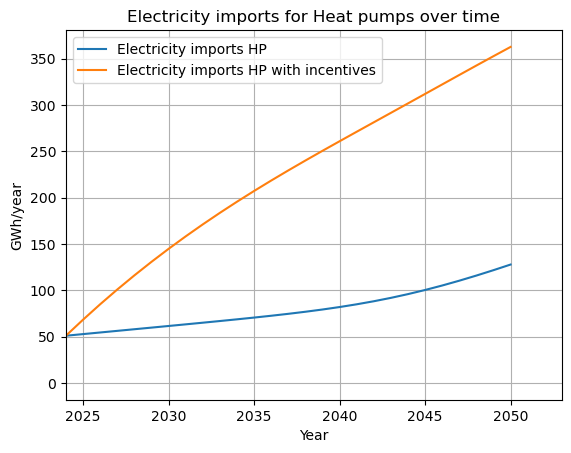

In [112]:
# plot electricity imports
plt.grid()
plt.plot( HP_DSM.t,Elec_imports, label='Electricity imports HP')
plt.plot( HP_DSM_incentive.t,Elec_imports_inc, label='Electricity imports HP with incentives')
plt.title('Electricity imports for Heat pumps over time')
plt.xlabel('Year')
plt.xlim(2024)
plt.ylabel('GWh/year')
plt.legend()

## Gas imports

In [113]:
# Gas needs per household
gas_need_GB= S_household*cons_surface/(LHV_gas*1000*efficiency_GB)*3600  #kg/year

# gas needs total per year
Gas_imports=np.array(GB_DSM.s[20:])*gas_need_GB/1000000  #kt/year


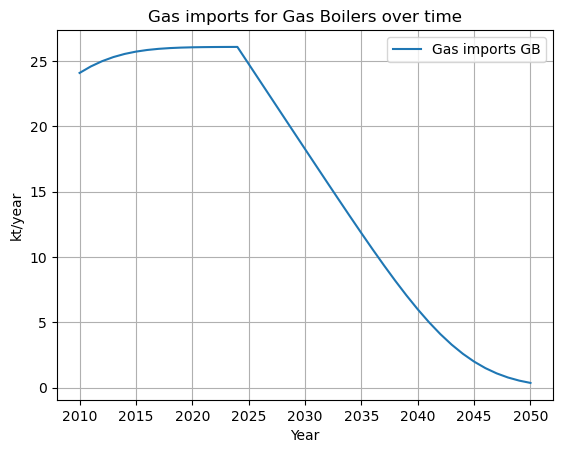

In [114]:
# plot gas imports
plt.grid()
plt.plot( GB_DSM.t[20:],Gas_imports, label='Gas imports GB')
plt.title('Gas imports for Gas Boilers over time')
plt.xlabel('Year')
plt.ylabel('kt/year')
plt.legend()

## $CO_2$ emissions
We use scope 3

In [115]:
# HP $CO_2$ emissions
CO2_emissions_HP= Elec_imports*1000*e_elec + HP_DSM.i*e_HP_manufacture #tCO2/year
CO2_emissions_HP_inc=Elec_imports_inc*1000*e_elec + HP_DSM_incentive.i*e_HP_manufacture #tCO2/year

# GB $CO_2$ emissions
CO2_emissions_GB= S_household*cons_surface*GB_DSM.s[20:]*e_gas_boiler*1000 #tCO2/year
# GB $CO_2$ emissions
CO2_emissions_GB_corrigé= S_household*cons_surface / efficiency_GB * 3.6 *GB_DSM.s[20:] * e_gas_boiler / 1000 #tCO2/year
# Primary energy (with the lost of the yield ) [kWh/an] * 3.6 ( conversion 1 kWh = 3.6 MJ) * e_gas_boiler [kgCO2/MJ] / 1000 to have in T   !! 

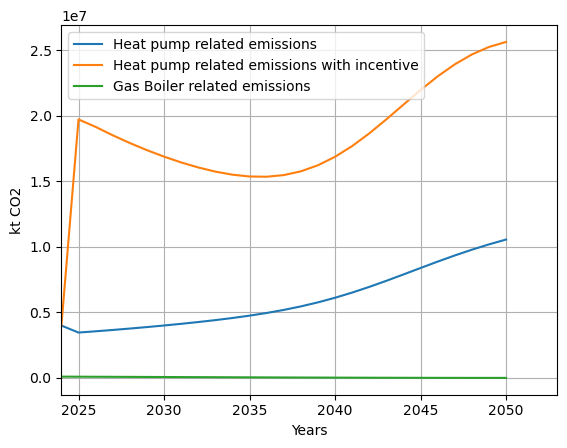

In [116]:
# Plot emissions per energy use per year
plt.grid()
#plt.plot(GB_DSM.t[20:], CO2_emissions_GB, label='Gas boiler related emissions')
plt.plot(HP_DSM.t, CO2_emissions_HP, label='Heat pump related emissions')
plt.plot(HP_DSM_incentive.t, CO2_emissions_HP_inc, label='Heat pump related emissions with incentive')
plt.plot(GB_DSM.t[20:], CO2_emissions_GB_corrigé, label='Gas Boiler related emissions')
plt.xlabel('Years')
plt.xlim(2024)
plt.ylabel('kt CO2')
plt.legend()

## Copper flows

In [117]:
# recycle coefficient
k=0.61

# Copper stocks
Copper_HP_s=np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_s=np.array(HP_DSM_incentive.s)*copper_HP
Copper_GB_s=np.array(GB_DSM.s)*copper_GB

# Copper exports
Copper_HP_o=(1-k)*np.array(HP_DSM.o)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP
Copper_HP_inc_i=np.array(HP_DSM_incentive.i)*copper_HP-k*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_i=np.array(GB_DSM.i)*copper_GB-k*np.array(GB_DSM.o)*copper_GB


# Sensitivity Analysis  

In [118]:

# Function to recalculate KPI 

def compute_kpis(COP_value, e_elec_value, efficiency_GB_value, e_gas_boiler_value):
 
  # DATA OF OUR MODEL 

  Years_HP = np.array(HP_DSM.t)                 #  1990–2050 
  HP_stock_base = np.array(HP_DSM.s)           
  HP_stock_inc  = np.array(HP_DSM_incentive.s)
  HP_in_base = np.array(HP_DSM.i)              # inflow HP baseline (nouvelles HP/an)
  HP_in_inc  = np.array(HP_DSM_incentive.i)    # inflow HP incitation

  
  years_GB_full = np.array(GB_DSM.t)           # Gas Boiler Years (2004–2050)
  GB_stock_full = np.array(GB_DSM.s)           # stock of GB 
  Years_GB = years_GB_full[20:]
  GB_stock = GB_stock_full[20:]

  # CALCULATION 

  elec_need_HP_per_house = S_household * cons_surface / COP_value

  Elec_imports_base = HP_stock_base * elec_need_HP_per_house / 1e6
  Elec_imports_inc  = HP_stock_inc  * elec_need_HP_per_house / 1e6

  # Emissions of HP AND GB [tCO2/an]
  
  CO2_HP_base = Elec_imports_base * 1000 * e_elec_value + HP_in_base * e_HP_manufacture
  CO2_HP_inc  = Elec_imports_inc  * 1000 * e_elec_value + HP_in_inc  * e_HP_manufacture

  CO2_GB_series = S_household*cons_surface / efficiency_GB_value * GB_stock * 3.6 * e_gas_boiler_value / 1000 #tCO2/year  # [tCO2/an]


  # Cumuls 2024–2050 

  mask_HP = Years_HP >= 2024
  mask_GB = Years_GB >= 2024

  CO2_HP_base_cum  = CO2_HP_base[mask_HP].sum()
  CO2_HP_inc_cum   = CO2_HP_inc[mask_HP].sum()
  CO2_GB_cum       = CO2_GB_series[mask_GB].sum()



  return {
    "CO2_HP_base_cum":  CO2_HP_base_cum,
    "CO2_HP_inc_cum":   CO2_HP_inc_cum,
    "CO2_GB_cum":       CO2_GB_cum,
  }


# One parameter at time 


In [119]:
def sensitivity_param(param_name, base_value, values_to_test):
    
    print(f"\nSensibility in function of: {param_name}")
    print(f"Base Value : {base_value:.4f}")
    print(f"Tested values : {', '.join(f'{v:.4f}' for v in values_to_test)}")

    
    results = []

    for val in values_to_test:
        # to change the god parameter 
        COP_test           = COP           if param_name != "COP"           else val
        efficiency_GB_test = efficiency_GB if param_name != "efficiency_GB" else val
        e_elec_test        = e_elec        if param_name != "e_elec"        else val
        e_gas_test         = e_gas_boiler  if param_name != "e_gas_boiler"  else val

        res = compute_kpis(COP_test, e_elec_test, efficiency_GB_test, e_gas_test)
        results.append((val, res))

    # TRUE KPI
    base_res = None
    for (val, res) in results:
        if abs(val - base_value) < 1e-9:
            base_res = res
            break

    if base_res is None:
        print("Warning: No value is the true base value.")
        return None
    
    CO2_base_HP_inc  = base_res["CO2_HP_inc_cum"]
    CO2_base_HP      = base_res["CO2_HP_base_cum"]
    CO2_base_GB      = base_res["CO2_GB_cum"]

    
    print("\nValue\t\tCO2_HP_inc (tCO2)\tΔ vs base\tCO2_HP_base (tCO2)\tΔ vs base\tCO2_GB (tCO2)\tΔ vs base")

    values_list       = []
    CO2_HP_inc_list   = []
    CO2_HP_base_list  = []
    CO2_GB_list       = []
    d_inc_list        = []
    d_base_list       = []
    d_GB_list         = []

    for (val, res) in results:
        CO2_HP_inc_cum = res["CO2_HP_inc_cum"]
        CO2_HP_cum     = res["CO2_HP_base_cum"]
        CO2_GB_cum     = res["CO2_GB_cum"]

        d_inc  = 100 * (CO2_HP_inc_cum  - CO2_base_HP_inc) / CO2_base_HP_inc  if CO2_base_HP_inc  != 0 else 0.0
        d_base = 100 * (CO2_HP_cum      - CO2_base_HP)     / CO2_base_HP      if CO2_base_HP      != 0 else 0.0
        d_GB   = 100 * (CO2_GB_cum      - CO2_base_GB)     / CO2_base_GB      if CO2_base_GB      != 0 else 0.0

        print(f"{val:.4f}\t{CO2_HP_inc_cum:12.0f}\t{d_inc:+6.1f} %\t"
              f"{CO2_HP_cum:12.0f}\t{d_base:+6.1f} %\t"
              f"{CO2_GB_cum:12.0f}\t{d_GB:+6.1f} %")

        
        values_list.append(val)
        CO2_HP_inc_list.append(CO2_HP_inc_cum)
        CO2_HP_base_list.append(CO2_HP_cum)
        CO2_GB_list.append(CO2_GB_cum)
        d_inc_list.append(d_inc)
        d_base_list.append(d_base)
        d_GB_list.append(d_GB)

    
    return {
        "param": param_name,
        "base_value": base_value,
        "values": values_list,
        "CO2_HP_inc": CO2_HP_inc_list,
        "CO2_HP_base": CO2_HP_base_list,
        "CO2_GB": CO2_GB_list,
        "d_CO2_HP_inc": d_inc_list,
        "d_CO2_HP_base": d_base_list,
        "d_CO2_GB": d_GB_list,
    }



factors = [0.8, 1.0, 1.2]

# Sensibility of parameters 
#  
COP_values = [f * COP for f in factors]
sens_COP= sensitivity_param("COP", COP, COP_values)

e_elec_values = [f * e_elec for f in factors]
sens_elec = sensitivity_param("e_elec", e_elec, e_elec_values)

eff_GB_values = [f * efficiency_GB for f in factors]
sens_effGB = sensitivity_param("efficiency_GB", efficiency_GB, eff_GB_values)

e_gas_values = [f * e_gas_boiler for f in factors]
sens_gas = sensitivity_param("e_gas_boiler", e_gas_boiler, e_gas_values)



Sensibility in function of: COP
Base Value : 3.2600
Tested values : 2.6080, 3.2600, 3.9120

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
2.6080	   493930351	  +0.0 %	   161878687	  +0.0 %	     1091368	  +0.0 %
3.2600	   493889524	  +0.0 %	   161863980	  +0.0 %	     1091368	  +0.0 %
3.9120	   493862305	  -0.0 %	   161854176	  -0.0 %	     1091368	  +0.0 %

Sensibility in function of: e_elec
Base Value : 0.0273
Tested values : 0.0218, 0.0273, 0.0328

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.0218	   493856861	  -0.0 %	   161852215	  -0.0 %	     1091368	  +0.0 %
0.0273	   493889524	  +0.0 %	   161863980	  +0.0 %	     1091368	  +0.0 %
0.0328	   493922186	  +0.0 %	   161875746	  +0.0 %	     1091368	  +0.0 %

Sensibility in function of: efficiency_GB
Base Value : 0.9000
Tested values : 0.7200, 0.9000, 1.0800

Value		CO2_HP_inc (tCO2)	Δ vs base	CO2_HP_base (tCO2)	Δ vs base	CO2_GB (tCO2)	Δ vs base
0.7200

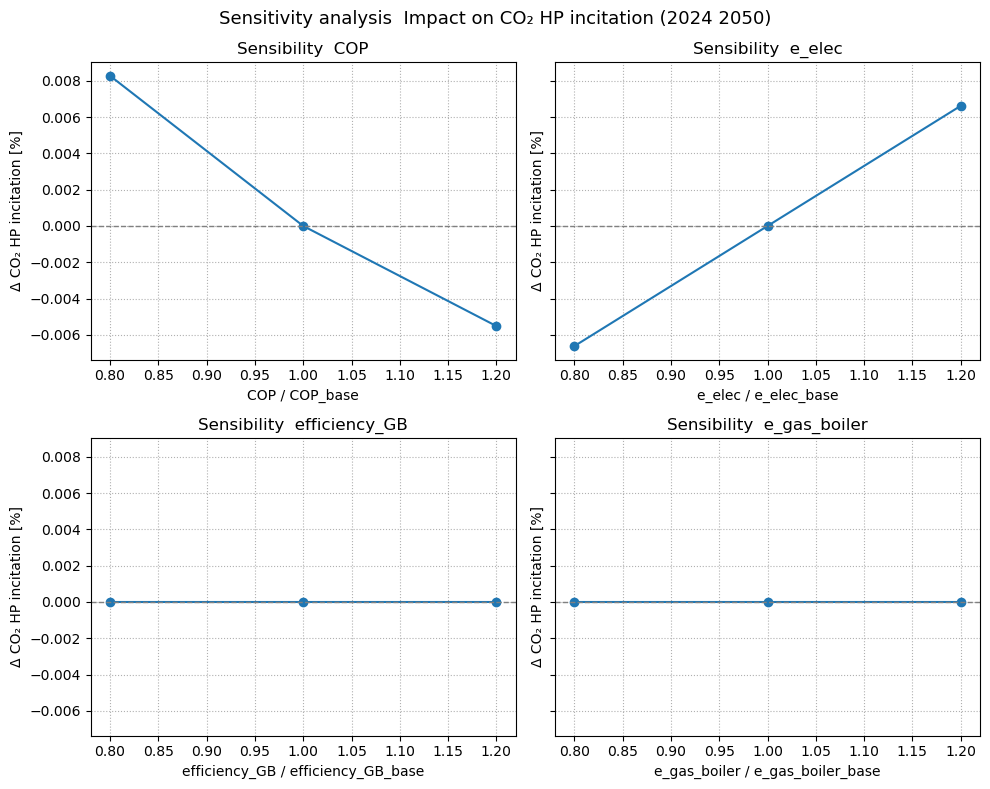

In [120]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_inc"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ HP incitation (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()




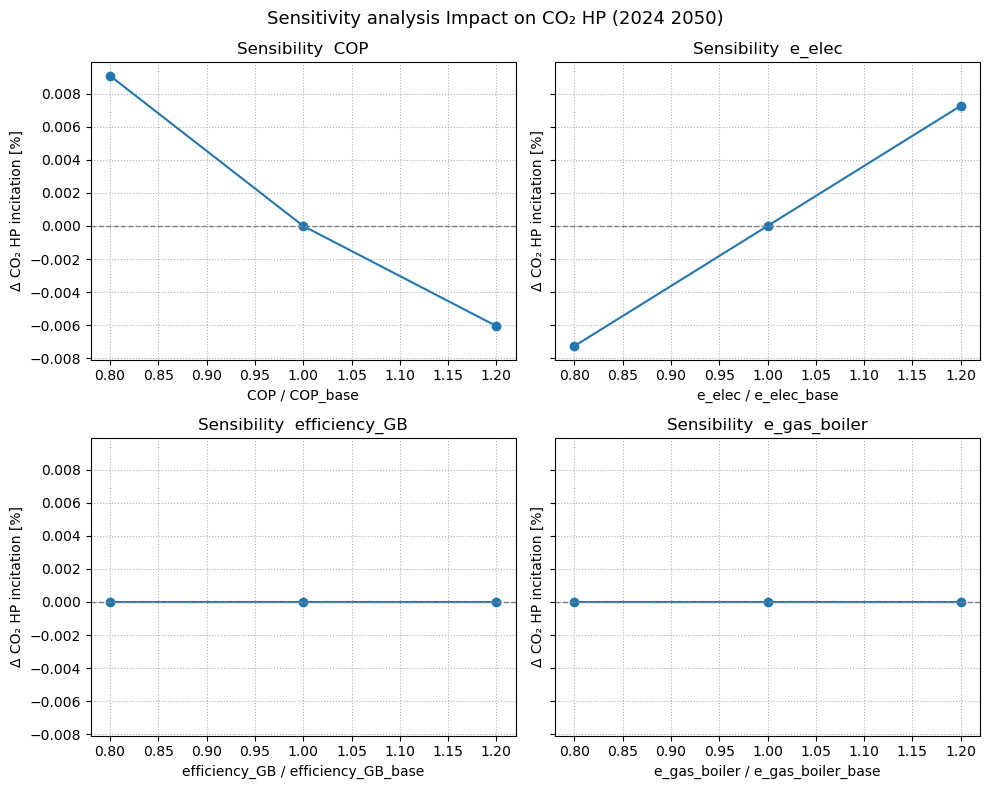

In [121]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_HP_base"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis Impact on CO₂ HP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()

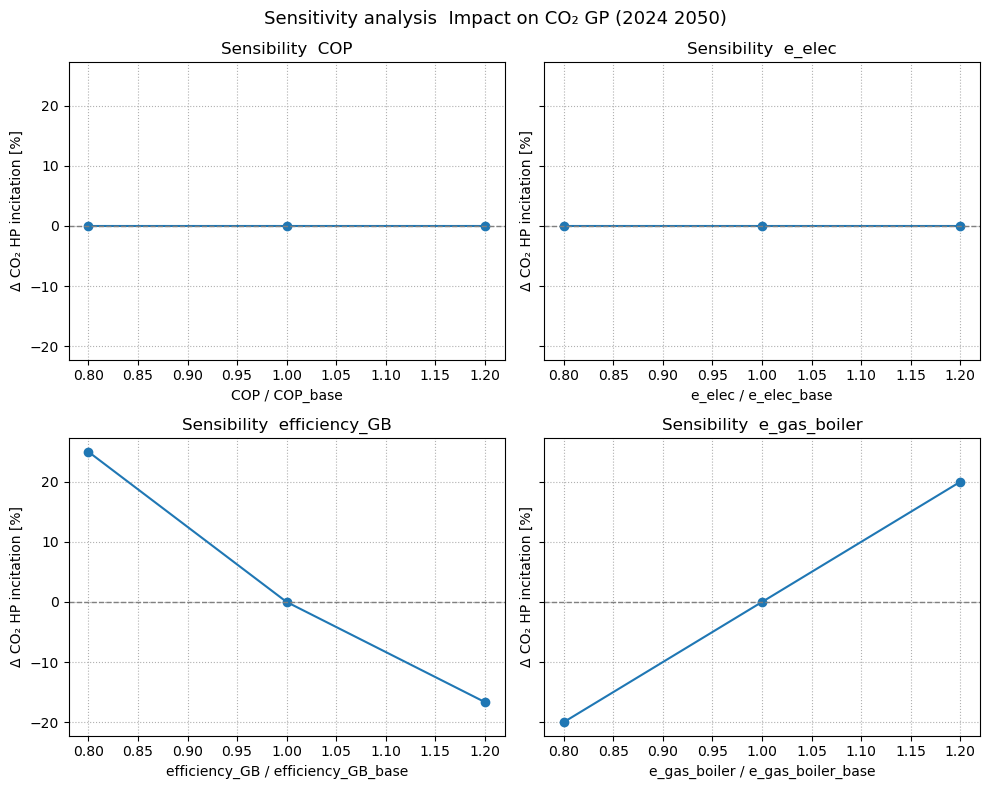

In [122]:
all_sens = [sens_COP, sens_elec, sens_effGB, sens_gas]

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharey=True)
axes = axes.flatten()

for ax, sens in zip(axes, all_sens):
    param_name = sens["param"]
    base_val   = sens["base_value"]
    x_values   = np.array(sens["values"]) / base_val     # normalisation (0.8, 1.0, 1.2)
    y_rel      = sens["d_CO2_GB"]                    # Δ CO2 HP incitation [%]

    ax.plot(x_values, y_rel, marker="o")
    ax.axhline(0, color="grey", linestyle="--", linewidth=1)
    ax.grid(True, linestyle=":")

    ax.set_title(f"Sensibility  {param_name}")
    ax.set_xlabel(f"{param_name} / {param_name}_base")
    ax.set_ylabel("Δ CO₂ HP incitation [%]")

fig.suptitle("Sensitivity analysis  Impact on CO₂ GP (2024 2050)", fontsize=13)
plt.tight_layout()
plt.show()

In [123]:
def compute_kpis_copper(k_value, copper_HP_value, copper_GB_value):

 
    # HP baseline
    Cu_HP_imports = np.array(HP_DSM.i) * copper_HP_value     
    Cu_HP_stock   = np.array(HP_DSM.s) * copper_HP_value      
    Cu_HP_exports = np.array(HP_DSM.o)  * copper_HP_value

    # HP incitation
    Cu_HP_inc_imports = np.array(HP_DSM_incentive.i) * copper_HP_value
    Cu_HP_inc_stock   = np.array(HP_DSM_incentive.s) * copper_HP_value
    Cu_HP_inc_exports = np.array(HP_DSM_incentive.o) * copper_HP * (1-k)

    # GB 
    Cu_GB_imports = np.array(GB_DSM.i) * copper_GB_value
    Cu_GB_exports = np.array(GB_DSM.o) * copper_GB_value * (1 - k_value)
    Cu_GB_stock   = np.array(GB_DSM.s) * copper_GB_value

    Cu_imports_total = Cu_HP_imports.sum() + Cu_HP_inc_imports.sum() + Cu_GB_imports.sum() - (np.array(GB_DSM.o) * copper_GB_value *  k_value).sum() - (np.array(HP_DSM_incentive.o) * copper_HP * k).sum() #the copper we reuse for recovering is no need to import 
    Cu_exports_total = Cu_GB_exports.sum() + Cu_HP_inc_exports.sum() + Cu_HP_exports.sum()
    Cu_stock_final   = Cu_HP_stock[-1] + Cu_HP_inc_stock[-1] + Cu_GB_stock[-1]

    return {
        "Cu_imports_total": Cu_imports_total,
        "Cu_exports_total": Cu_exports_total,
        "Cu_stock_final":   Cu_stock_final,
    }
# Copper stocks

Copper_HP_o=(1-k)*np.array(HP_DSM.s)*copper_HP

Copper_HP_inc_o=(1-k)*np.array(HP_DSM_incentive.o)*copper_HP
Copper_GB_o=(1-k)*np.array(GB_DSM.o)*copper_GB

# Copper imports
Copper_HP_i=np.array(HP_DSM.i)*copper_HP-k*np.array(HP_DSM.s)*copper_HP

In [124]:
def sensitivity_copper(param_name, base_value, values_to_test):
  
    results = []

    for val in values_to_test:
        k_test      = k          if param_name != "k"          else val
        Cu_HP_test  = copper_HP  if param_name != "copper_HP"  else val
        Cu_GB_test  = copper_GB  if param_name != "copper_GB"  else val

        kpis = compute_kpis_copper(k_test, Cu_HP_test, Cu_GB_test)
        results.append(kpis)
    base_idx  = len(values_to_test) // 2  
    base_kpis = results[base_idx]

    return {
        "param":   param_name,
        "values":  values_to_test,
        "imports": [r["Cu_imports_total"] for r in results],
        "exports": [r["Cu_exports_total"] for r in results],
        "stock":   [r["Cu_stock_final"]   for r in results],
        "base":    base_kpis,
    }

factors = [0.8, 1.0, 1.2]

results_k  = sensitivity_copper("k", k, [f * k for f in factors])
results_HP = sensitivity_copper("copper_HP", copper_HP, [f * copper_HP for f in factors])
results_GB = sensitivity_copper("copper_GB", copper_GB, [f * copper_GB for f in factors])

print("k:", results_k)
print("copper_HP:", results_HP)
print("copper_GB:", results_GB)

k: {'param': 'k', 'values': [0.488, 0.61, 0.732], 'imports': [np.float64(18623014.562055655), np.float64(18586687.967000753), np.float64(18550361.37194585)], 'exports': [np.float64(4592102.895893884), np.float64(4555776.30083898), np.float64(4519449.705784076)], 'stock': [np.float64(14030911.66616178), np.float64(14030911.66616178), np.float64(14030911.66616178)], 'base': {'Cu_imports_total': np.float64(18586687.967000753), 'Cu_exports_total': np.float64(4555776.30083898), 'Cu_stock_final': np.float64(14030911.66616178)}}
copper_HP: {'param': 'copper_HP', 'values': [20.0, 25.0, 30.0], 'imports': [np.float64(14297982.734025588), np.float64(18586687.967000753), np.float64(22875393.199975923)], 'exports': [np.float64(4048301.613842096), np.float64(4555776.30083898), np.float64(5063250.987835865)], 'stock': [np.float64(11225207.717757449), np.float64(14030911.66616178), np.float64(16836615.614566106)], 'base': {'Cu_imports_total': np.float64(18586687.967000753), 'Cu_exports_total': np.floa

<Figure size 700x500 with 0 Axes>

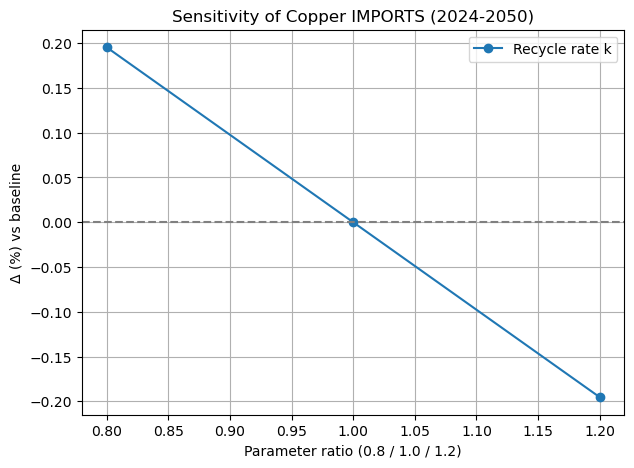

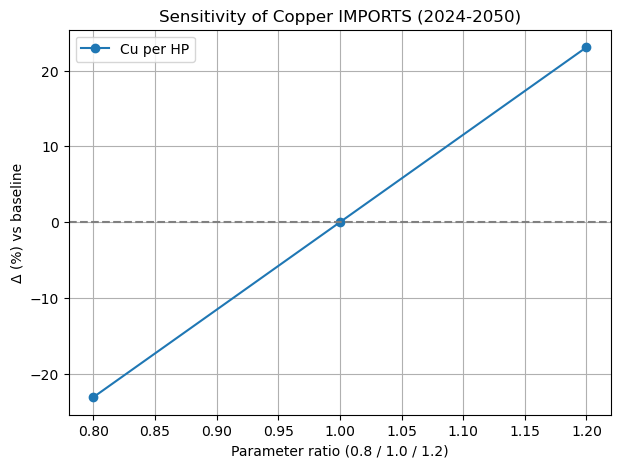

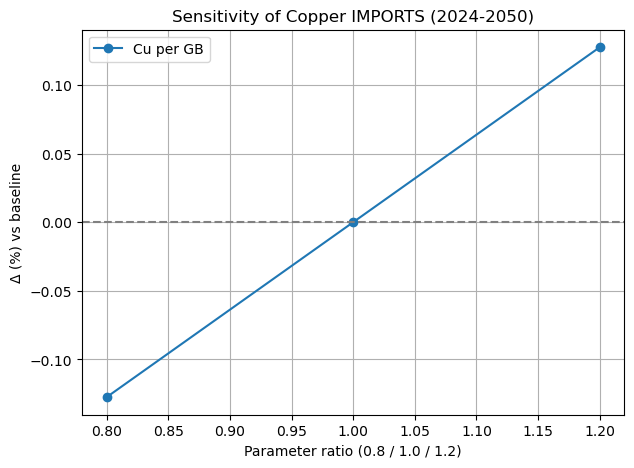

In [125]:
# ----- Parameters -----
kpi_name = "imports"   # "imports", "exports", "stock"


if kpi_name == "imports":
    key = "Cu_imports_total"
elif kpi_name == "exports":
    key = "Cu_exports_total"
elif kpi_name == "stock":
    key = "Cu_stock_final"


plt.figure(figsize=(7,5))

labels = {"k":"Recycle rate k", "copper_HP":"Cu per HP", "copper_GB":"Cu per GB"}
params = [results_k, results_HP, results_GB]

for res in params:

    base = res["base"][key]

    
    tested_values = res[kpi_name]     # ex : res["imports"]

    
    deltas = [(v - base)/base * 100 for v in tested_values]

    plt.figure(figsize=(7,5))
    plt.plot([0.8, 1.0, 1.2], deltas, marker="o", label=labels[res["param"]])

    plt.axhline(0, color="gray", linestyle="--")
    plt.title(f"Sensitivity of Copper {kpi_name.upper()} (2024-2050)")
    plt.xlabel("Parameter ratio (0.8 / 1.0 / 1.2)")
    plt.ylabel("Δ (%) vs baseline")
    plt.grid(True)
    plt.legend()
    plt.show()